# Statistical Regression and Classification | Sample Problems

#### [From the book Statistical Regression and Classification From Linear Models to Machine Learning](https://www.amazon.com/Statistical-Regression-Classification-Machine-Learning-ebook/dp/B075RG9PWR)

In [13]:
## install primary libraries
library(regtools)
library(freqparcoord)
library(mfp)
library(PerformanceAnalytics)

### Page 61, #'s 1-4

#### 1.) In Section 1.12.1.2, the reader was reminded that the results of a cross-validation are random, due to the random partitioning into training and test sets. Try doing several runs of the linear and k-NN code in that section, comparing results.

In [6]:
## value part function
xvalpart <- function(data,p) {
  n <- nrow(data)
  ntrain <- round(p*n)
  trainidxs <- sample(1:n,ntrain,replace = FALSE)
  list(train = data[trainidxs,],
       valid = data[-trainidxs,])
}

## linear model function
xvallm <- function (data,ycol,predvars,p,meanabs=TRUE) {
  tmp <- xvalpart(data,p)
  train <- tmp$train
  valid <- tmp$valid
  # fit model to training data
  trainy <- train[,ycol]
  trainpreds <- train[,predvars]
  # using a matrix form in lm() call
  trainpreds <- as.matrix(trainpreds)
  lmout <- lm(trainy ~ trainpreds)
  # apply fitted model to validation data; note
  # that %*% works only on matrices, not dat frames
  validpreds <- as.matrix(valid[,predvars])
  predy <- cbind(1,validpreds) %*% coef(lmout)
  realy <- valid[,ycol]
  if (meanabs) return(mean(abs(predy - realy)))
  list(predy = predy, realy = realy)
}

## k-nn model function
xvalknn <- function(data,ycol,predvars,k,p,meanabs=TRUE) {
  data <- data[,c(predvars,ycol)]
  ycol <- length(predvars) + 1
  tmp <- xvalpart(data,p)
  train <- tmp$train
  valid <- tmp$valid
  valid <- as.matrix(valid)
  xd <- preprocessx(train[,-ycol],k)
  kout <- knnest(train[,ycol],xd,k)
  predy <- predict(kout,valid[,-ycol],TRUE)
  realy <- valid[,ycol]
  if (meanabs) return(mean(abs(predy - realy)))
  list(predy = predy, realy = realy)
}

In [38]:
## run simulations
data(mlb)
lm_results <- c(replicate(10,xvallm(mlb,5,c(4,6),2/3)))
knn_results <- c(replicate(10,xvalknn(mlb,5,c(4,6),25,2/3)))
delta <- abs(lm_results-knn_results)
result_matrix <- as.matrix(cbind(lm_results,knn_results,delta))
colnames(result_matrix) <- c("Linear Results","KNN Results","Delta (abs)")
result_matrix
l_var <- var(result_matrix[,1])
l_delta <- var(result_matrix[,3])
print(sprintf("Variance between linear results: %s. Variance between delta: %s.",l_var,l_delta),quote = FALSE)

Linear Results,KNN Results,Delta (abs)
13.71722,14.26899,0.55177176
13.68654,13.78556,0.09902476
13.60688,13.86970,0.26282527
13.51292,13.24497,0.26794659
14.10435,14.20982,0.10547035
13.30243,13.73089,0.42846205
13.06079,14.47953,1.41873646
13.85474,13.76840,0.08634126
13.32756,14.53822,1.21066052
14.11263,14.22355,0.11091628


[1] Variance between linear results: 0.117361693220488. Variance between delta: 0.23166511009931.


#### 2.) Extend (1.28) to include interaction terms for age and gender, and age^2 and gender. Run the new model, and find the estimated effect of being female, for a 32-year-old person with a Master's degree.

In [10]:
## first part of modeling
data(prgeng)
prgeng$age2 <- prgeng$age^2
edu <- prgeng$educ
prgeng$ms <- as.integer(edu == 14)
prgeng$phd <- as.integer(edu == 16)
prgeng$fem <- prgeng$sex - 1
tmp <- prgeng[edu >= 13,]
# subset data frame by specific columns
pe <- tmp[,c(1,12,9,13,14,15,8)]
# use as to call out the matrix in-place
pe <- as.matrix(pe)
# pe
lm(wageinc ~ age+age2+wkswrkd+ms+phd+fem,data=prgeng)


Call:
lm(formula = wageinc ~ age + age2 + wkswrkd + ms + phd + fem, 
    data = prgeng)

Coefficients:
(Intercept)          age         age2      wkswrkd           ms          phd  
  -81136.70      3900.35       -40.33      1196.39     15431.07     23183.97  
        fem  
  -11484.49  


In [11]:
## second part of modeling
wage.lm <- lm(wageinc ~ age+age2+wkswrkd+ms+phd+fem+age:fem+age2:fem,data=prgeng)
predict_data <- data.frame(age=32,age2=32^2,wkswrkd=52,ms=1,phd=0,fem=1,agefem=32*1,agefem2=(32^2)*1)
predict(wage.lm,predict_data,interval="predict")

,fit,lwr,upr
1,69086.59,-14477.21,152650.4


#### 3.) Consider the bodyfat data mentioned in Section 1.2. Use lm() to form a prediction equation for density from the other variables (skipping the first three), and comment on whether use of indirect methods in this way seems feasible.

In [18]:
data(bodyfat)
body_data <- bodyfat[,4:17]
trim_body_data <- bodyfat[,c(4,9,10,11)]
body.lm <- lm(density ~ chest + abdomen + hip, trim_body_data)
summary(body.lm)


Call:
lm(formula = density ~ chest + abdomen + hip, data = trim_body_data)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.027490 -0.007744 -0.000218  0.007254  0.045280 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.1245929  0.0122067  92.129  < 2e-16 ***
chest        0.0005467  0.0002038   2.682   0.0078 ** 
abdomen     -0.0023376  0.0001832 -12.757  < 2e-16 ***
hip          0.0009230  0.0001983   4.655 5.27e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.01081 on 248 degrees of freedom
Multiple R-squared:  0.6811,	Adjusted R-squared:  0.6773 
F-statistic: 176.6 on 3 and 248 DF,  p-value: < 2.2e-16


![Chart Image](https://raw.githubusercontent.com/danehamlett/UC_Davis/master/Regression_Classification/body_chart.png)

The use of indirect methods does not seem feasible, by purely using indirect methods.  In order to pair down the model, and identify the most meaningul variables, I was able to first assess the pearson correlation coefficients between variables, and develop a meaningful model from there.

#### 4.) In Section 1.19.5.2, we gave this intuitive explanation:
    
####    In other words, the national mean height is a weighted average of the state means, with the weight for each state being its proportion of the national population. Replace state by gender in the following.

1. Write English prose that relates the overall mean height of people and the gender-specific mean heights.
2. Write English prose that relates the overall proportion of people taller than 70 inches to the gender-specific proportions.

* In order to compute the mean height of all people, you would need to implement a weighted average of the gender means, with the weight for each gender being its proportion of the total population.  For example, if fifty percent of the population was female, a fifty percent weight would be applied to each female height (a comparable weight would be applied to each male height), those values would be aggregated, and the divided by the the aggregate total of both proportions.

* In order to compute the mean height of all people, factoring in gender and people who are taller than 70 inches, you would need to implement a weighted average of the means for each gender with people who are taller than 70 inches and less than 70 inches.

### Page 120, #'s 1-4

#### 1.) Consider the census data in Section 1.16.1.

1. Form an approximate 95% confidence interval for B6 in the model (1.28).
2. Form an approximate 95% confidence interval for the gender effect for Master's degree holders, B6 + B7, in the model (1.28).

In [23]:
data(prgeng)
prgeng$age2 <- prgeng$age^2
edu <- prgeng$educ
prgeng$ms <- as.integer(edu == 14)
prgeng$phd <- as.integer(edu == 16)
prgeng$fem <- prgeng$sex - 1
prgeng$msfem <- prgeng$ms * prgeng$fem
tmp <- prgeng[edu >= 13,]
# subset data frame by specific columns
pe <- tmp[,c(1,12,9,13,14,15,8)]
# use as to call out the matrix in-place
pe <- as.matrix(pe)

# linear modeling
wage_lm <- lm(wageinc ~ age+age2+wkswrkd+ms+phd+fem,data=prgeng)
wage_lm_sum <- summary(wage_lm)

# 95% Confidence Interval
fem_fac <- wage_lm$coefficients[7]
s <- sd(prgeng$fem,na.rm = TRUE)
df <- wage_lm$df.residual
fem_var <- df*(s^2)

t95 <- qt(.975,df)
l95 <- fem_fac - (t95*sqrt(wage_lm_sum$sigma/fem_var))
u95 <- fem_fac + (t95*sqrt(wage_lm_sum$sigma/fem_var))

l95_rounded <- round(l95, digits = 2)
u95_rounded <- round(u95, digits = 2)

# Print the 95% Confidence Interval
print(sprintf("95 percent Confidence Interval: (%s, %s)",l95_rounded,u95_rounded),quote = FALSE)

[1] 95 percent Confidence Interval: (-11491.14, -11477.84)


**Interpretation:** For every unit increase in the female population, we can be 95% confident that the estimated female income will be between \$11,477.84 and \$11,481.14 lower than a comparable male's income.

In [25]:
# additional linear modeling
new_wage_lm <- lm(wageinc ~ age+age2+wkswrkd+ms+phd+fem+msfem,data=prgeng)
new_wage_lm_sum <- summary(new_wage_lm)

# 95% Confidence Interval
new_fem_fac <- new_wage_lm$coefficients[8]
new_s <- sd(prgeng$msfem,na.rm = TRUE)
new_df <- new_wage_lm$df.residual
new_fem_var <- new_df*(new_s^2)

new_t95 <- qt(.975,new_df)
new_l95 <- new_fem_fac - (new_t95*sqrt(new_wage_lm_sum$sigma/new_fem_var))
new_u95 <- new_fem_fac + (new_t95*sqrt(new_wage_lm_sum$sigma/new_fem_var))

new_l95_rounded <- round(new_l95, digits = 2)
new_u95_rounded <- round(new_u95, digits = 2)

# Print the 95% Confidence Interval
print(sprintf("95 percent Confidence Interval: (%s, %s)",new_l95_rounded,new_u95_rounded),quote = FALSE)

[1] 95 percent Confidence Interval: (-3742.4, -3716.32)


**Interpretation:** For every unit increase in the female population (who also have masters degrees), we can be 95% confident that the estimated female income will be between \$3,716.32 and \$3,742.40 lower than a comparable male's income.

#### 2.) Consider the census data in Section 1.16.1.

The full bikeshare dataset spans 3 years' time. Our analyses here have only used the first year. Extend the analysis in Section 2.8.5 to the full data set, adding dummy variables indicating the second and third year. Form an approximate 95% confidence interval for the difference between the coefficients of these two dummies.

[There are only two years of data in this data set](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset)

In [28]:
# import and modify data
library(readr)
bike <- read.csv("~/Desktop/School/Machine Learning/Bike-Sharing-Dataset/day.csv")
bike$temp2 <- bike$temp^2
bike$reg <- bike$registered
clear <- bike$weather
bike$clearday <- as.integer(clear == 1)

# linear modeling
lmout <- lm(reg ~ temp+temp2+workingday+clearday+yr,data=bike)

# 95% Confidence Interval
lamb <- c(0,.154,0,.186,0,1)
m_est <-t(lamb) %*% coef(lmout)
m_se <- sqrt(t(lamb) %*% vcov(lmout) %*% lamb)
m_df <- lmout$df.residual
m_t95 <- qt(.975,m_df)
m_l95 <- m_est - (m_t95*m_se)
m_u95 <- m_est + (m_t95*m_se)

m_l95_rounded <- round(m_l95, digits = 2)
m_u95_rounded <- round(m_u95, digits = 2)

# Print the 95% Confidence Interval
print(sprintf("95 percent Confidence Interval: (%s, %s)",m_l95_rounded,m_u95_rounded),quote = FALSE)

[1] 95 percent Confidence Interval: (3831.77, 4405.74)


**Interpretation:** We can be 95% confident that the difference between the number of riders on warmer days in 2011 and 2012 will be between 3,831.77 and 4,405.74.

#### 3.) Suppose we are studying growth patterns in children, at k particular ages.

Denote the height of the ith child in our sample data at age j by Hij , with Hi = (Hi1, ... ,Hik)′ denoting the data for child i. Suppose the population distribution of each Hi is k-variate normal with mean vector mu and covariance matrix sigma. Say we are interested in successive differences in heights, Dij = Hi,j+1 - Hij,j = 1,2, ... ,k-1. Define Di = (Di1, ... ,Dik)′. Explain why each Di is (k-1)-variate normal, and derive matrix expressions for the mean vector and covariance matrices.

#### 4.) In the simulation in Section 2.9.3, it is claimed that p^2 = .50. Confirm this through derivation.

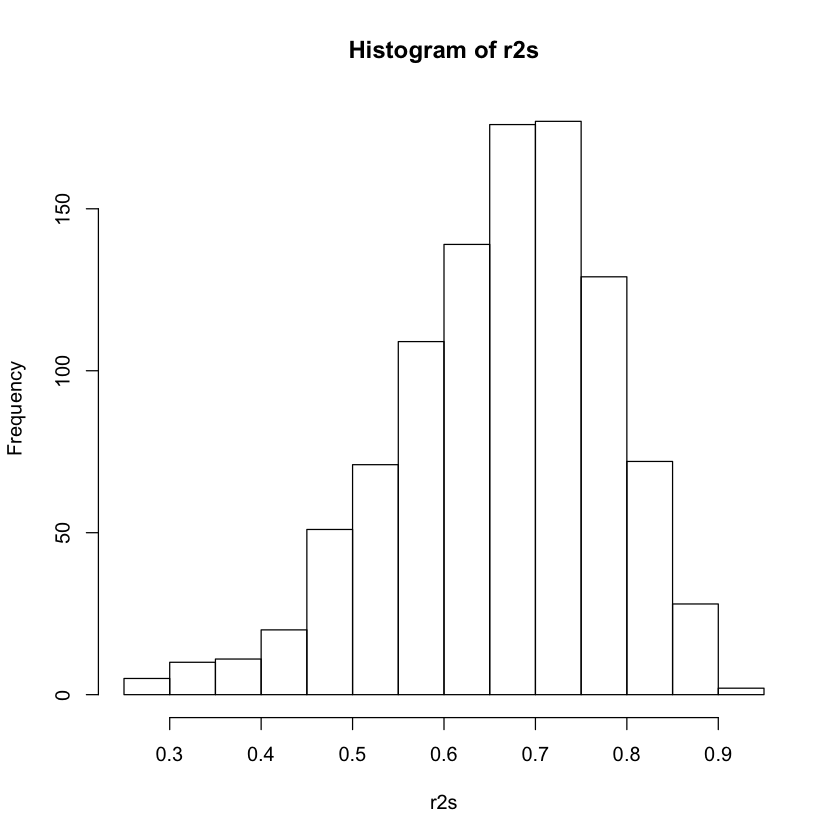

In [29]:
# linear regression simulation
simr2 <- function(n,p,nreps) {
  r2s <- vector(length=nreps)
  for (i in 1:nreps) {
    x <- matrix(rnorm(n*p),ncol=p)
    y <- x %*% rep(1,p) + rnorm(n,sd=sqrt(p))
    r2s[i] <- getr2(x,y)
  }
  hist(r2s)
}

getr2 <- function(x,y) {
  sum <- summary(lm(y~x))
  sum$r.squared
}

simr2(25,8,1000)

**Interpretation:** We can see that by running the above simulation, the bulk of r-squared (or p^2) values are closer to .7, than .5.

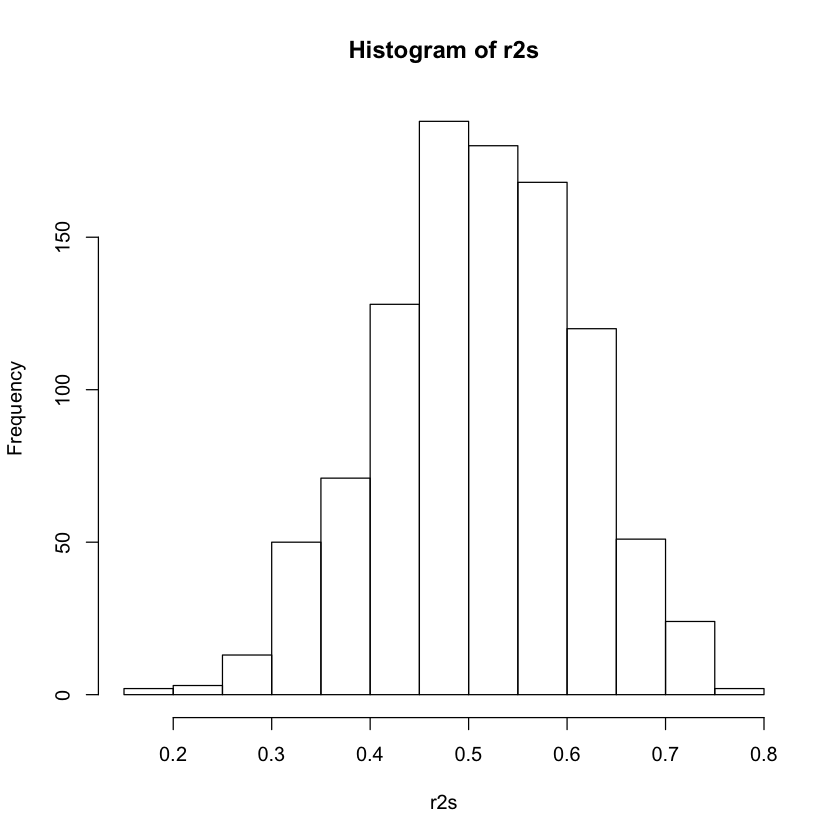

In [33]:
simr2(50,2,1000)

**Interpretation:** We can see that by running the above simulation, with an increased sample size and decreased number of predictors, the bulk of r-squared (or p^2) values are much closer to .5.